## ITCS494 Machine Learning
## Lab Assignment 3. Logistic Regression and Regularization

---------------------------------

**RAMSHA KHALID MUHAMMAD KHALID**

**20168013**

---------------------------------

**Objectives:**

1.   Implement logistic regression for binary classification
2.   Implement logistic regression for multiple classification 
3.   Add regularization and visualize the effect of changing the value of $\lambda$ on the overfitting probelm
4.   Test the model on 30% of the available data

**Problem:**

**Part 1: Binary classification (8 points)**

For this assignment you will use the data for the grades of an actual course. Note that for objective 1, we would like to build a model using the cost function that we derived in class for binary classification. This will predict the grade of the student if it is a pass (A,B,C,D) or non-pass (F,WF,W). You can use any of the give parameters to build your hypothesis. 
1.   This will involve implementing gradient descent.
2.   You should make it efficient using matrix and vector operations.
Please test the results by doing the training on only a randomly chosen set of students (70%) of the total, then testing your hypothesis on the remaining 30%. Calculate your success rate in predicting the test data.

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
#read data and rename columns
marks = pd.read_csv("csc103.csv", header=0, skiprows = [0,2])
marks.rename(columns={'T1.1':'test1','T2.1':'test2','Unnamed: 25':'mid', 'Unnamed: 33':'total', 'Unnamed: 34':'grade', 'Final.1':'final'}, inplace=True)
marks

,SEC,Q1,Q2,Q3,Q4,T1,test1,Q1.1,Q2.1,Q3.1,...,mid,Q1.3,Q2.3,Q3.2,Q4.2,Q5,Final,final,total,grade
0,1,8.0,7.0,7.5,11.0,33.5,16.7,3.0,2.0,10.8,...,45.8,11.8,11.5,14.0,5.0,12.0,54.3,27.1,73.0,C
1,1,8.0,8.6,7.5,12.0,36.1,18.1,5.0,5.5,8.0,...,50.5,13.5,12.0,15.0,4.0,8.0,52.5,26.3,77.0,B-
2,1,8.0,4.1,7.0,11.0,30.1,15.0,3.0,3.5,5.5,...,37.5,7.0,4.3,3.0,0.0,3.0,17.3,8.6,46.0,F
3,1,6.0,7.3,6.0,11.0,30.3,15.2,NaN,NaN,NaN,...,33.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F
4,1,3.0,3.3,8.0,10.5,24.8,12.4,1.5,3.0,7.5,...,37.6,7.0,8.5,9.0,2.0,3.0,29.5,14.8,52.0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,25,8.0,9.2,10.0,12.0,39.2,19.6,6.0,6.0,11.5,...,59.1,13.8,14.0,16.0,14.0,11.0,68.8,34.4,93.0,A
837,25,7.8,8.6,8.5,10.0,34.8,17.4,5.0,5.0,6.5,...,47.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F
838,25,6.0,4.7,4.0,9.0,23.7,11.9,1.0,4.5,1.0,...,29.5,4.5,1.0,3.5,2.0,3.0,14.0,7.0,37.0,F
839,25,7.3,4.5,9.5,8.0,29.3,14.6,6.0,6.0,9.5,...,48.5,12.0,3.0,16.0,10.0,17.0,58.0,29.0,77.0,B-


In [3]:
#drop all columns other than mid (marks out of 60), final (marks out of 40) and grade
marks.drop(marks.columns.difference(['mid','final','grade']), 1, inplace=True)

In [4]:
#drop all rows with any null cell value
marks.dropna(how='any', inplace=True)
data = marks.copy(deep=True)

In [5]:
#change all grades to binary values 
#1 for grade (A,A-,B+,B-,B,C+,C-,C,D+,D)
#0 for grade (F,W,WE,WF)
marks["grade"].replace({"A":1,"A-":1,"B+":1,"B-":1,"B":1,"C+":1,"C-":1,"C":1,"D":1,"D+":1,"WE":0,"WF":0,"W":0,"F":0},inplace=True)

In [6]:
#split the dataset into 70 : 30 for training and testing
train_set = marks.sample(frac=0.70, random_state=0)
test_set  = marks.drop(train_set.index)

In [7]:
#plot all the passed and failed of training data (part 3)
passed = train_set.loc[train_set['grade'] == 1]
failed = train_set.loc[train_set['grade'] == 0]

In [8]:
#split the features and target for training and testing datasets
trainY = train_set['grade']
testY = test_set['grade']

trainX = train_set.drop('grade',axis=1) 
testX = test_set.drop('grade', axis=1)

testData = testX.copy(deep=True)
testDate = pd.concat([pd.Series(1, index=testData.index, name='X0'), testData], axis=1)
#mean normalization and scaling of features
trainX = trainX.apply(lambda X: (X-X.mean())/X.max())
testX = testX.apply(lambda X: (X-X.mean())/X.max())

#add the bias value to feature datasets
trainX = pd.concat([pd.Series(1, index=trainX.index, name='X0'), trainX], axis=1)
testX = pd.concat([pd.Series(1, index=testX.index, name='X0'), testX], axis=1)

#training data X
trainX

,X0,mid,final
702,1,-0.069132,-0.177952
143,1,-0.264132,-0.285369
18,1,-0.085799,0.008749
686,1,0.032534,0.070130
513,1,0.182534,0.256831
...,...,...,...
488,1,0.024201,-0.055190
572,1,-0.105799,0.080360
297,1,-0.129132,0.134069
408,1,-0.135799,-0.280254


In [9]:
#training data y
trainY.to_frame()

,grade
702,0
143,0
18,1
686,1
513,1
...,...
488,1
572,1
297,1
408,0


In [10]:
#sigmoid function to return all values within range of 0 - 1
def sigmoid(h):
    return 1 / (1 + np.exp(-h))

In [11]:
#cost function to calculate cost of model
def cost(X,y,theta):
    m = len(y)
    hypothesis = sigmoid(X @ theta)
    cost = (1/m)*(((-y).T @ np.log(hypothesis))-((1-y).T @ np.log(1-hypothesis)))
    return cost

In [12]:
#gradient descent function to find the best theta
def gradient_descent(X, y, theta, rate, iterations):
    m = len(y)
    costs = []

    #find theta for the number of iterations
    for i in range(iterations):
        #calculate theta
        theta = theta - (rate/m) * (X.T @ (sigmoid(X @ theta) - y)) 
        #calculate cost
        c = cost(X, y, theta)
        costs.append(c)
        
        #print cost at each 100th iteration
        if(i % 100 == 0):
            print ("Cost at iteration ", i, " = ", c)

    return (costs, theta)

In [13]:
def predict(X, theta):
    return np.round(sigmoid(X @ theta))

In [14]:
def accuracy(theta, X, y):
    #calculate predictions for testing dataset
    pred = predict(X, theta)
    
    #set counter for correct predictions
    counter = 0
    
    for i in range(len(y)):
        #if correct prediction, increment counter
        if((pred.iloc[i] == 1 and y.iloc[i] == 1)or(pred.iloc[i] == 0 and y.iloc[i] == 0)):
            counter+=1
        
    #calculate accuracy of correct predictions    
    accurate = (counter/len(y))*100
    correct = counter
    
    #total - correct predictions = wrong predictions
    wrong = len(y) - counter
    
    return accurate, correct, wrong 

In [15]:
#Initialize values of iterations and learning rate
iterations = 1000
alpha = 0.5

#Initialize theta with 0s
theta = np.array([0]*len(trainX.columns))

In [16]:
c , theta = gradient_descent(trainX, trainY, theta, alpha, iterations)
th = theta
theta

Cost at iteration  0  =  0.6666614058727254
Cost at iteration  100  =  0.32809175602651086
Cost at iteration  200  =  0.2503309797950012
Cost at iteration  300  =  0.21278102338807636
Cost at iteration  400  =  0.18991979257610406
Cost at iteration  500  =  0.17418538373023212
Cost at iteration  600  =  0.16251199289026164
Cost at iteration  700  =  0.15340349621369068
Cost at iteration  800  =  0.14603486842338032
Cost at iteration  900  =  0.13990995369089454


X0       2.132705
mid      6.655618
final    9.896911
dtype: float64

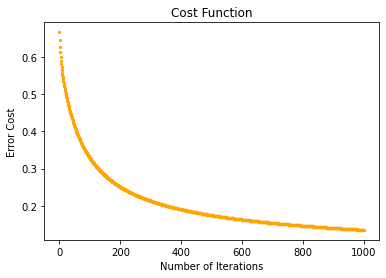

In [17]:
#Plot graph to visualize the cost function
plt.figure()
plt.title('Cost Function')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Cost')

plt.scatter(x=list(range(iterations)) , y=c, s=5, color="orange")
plt.show()

In [18]:
#prediction accuracy of test data
acc, correct, wrong = accuracy(theta, testX, testY)
print("Accuracy = ", np.ceil(acc), "%")
print("Correct predictions = ", correct)
print("Incorrect predictions = ", wrong)

Accuracy =  97.0 %
Correct predictions =  191
Incorrect predictions =  7



**Part 2: Multiclass classification (6 points)**

Implement multiclass logistic regression using also the functions we developed in class. (You cannot use a ready made algorithm from a library). Use matrix and vector operations and test it on predicting the grade: A,B,C,... etc.

In [19]:
#dividing data into 70:30 for training and testing
training_data = data.sample(frac=0.70, random_state=0)
testing_data  = data.drop(training_data.index)

#split features for tetsing and training
trainingY = training_data['grade']
Grades = testing_data['grade']

trainingX = training_data.drop('grade',axis=1) 
testingX = testing_data.drop('grade', axis=1)

#mean normalization and scaling of features
trainingX = trainingX.apply(lambda X: (X-X.mean())/(X.max()-X.min()))
testingX = testingX.apply(lambda X: (X-X.mean())/(X.max()-X.min()))

#add the bias value to feature datasets
trainingX = pd.concat([pd.Series(1, index=trainingX.index, name='X0'), trainingX], axis=1)
testingX = pd.concat([pd.Series(1, index=testingX.index, name='X0'), testingX], axis=1)

In [20]:
#make copies of trainingY for each class
# A, A-        -> A
# B+, B, B-    -> B
# C+, C, C-    -> C
# D+, D        -> D
# F, WE, WF, W -> F

yA = trainingY.copy(deep=True)
yB = trainingY.copy(deep=True)
yC = trainingY.copy(deep=True)
yD = trainingY.copy(deep=True)
yF = trainingY.copy(deep=True)

#Change grades to binary values for respective classes
yA.replace(
    {"A":1,"A-":1,"B+":0,"B-":0,"B":0,"C+":0,"C-":0,"C":0,"D":0,"D+":0,"WE":0,"WF":0,"W":0,"F":0},
    inplace=True)

yB.replace(
    {"A":0,"A-":0,"B+":1,"B-":1,"B":1,"C+":0,"C-":0,"C":0,"D":0,"D+":0,"WE":0,"WF":0,"W":0,"F":0},
    inplace=True)

yC.replace(
    {"A":0,"A-":0,"B+":0,"B-":0,"B":0,"C+":1,"C-":1,"C":1,"D":0,"D+":0,"WE":0,"WF":0,"W":0,"F":0},
    inplace=True)

yD.replace(
    {"A":0,"A-":0,"B+":0,"B-":0,"B":0,"C+":0,"C-":0,"C":0,"D":1,"D+":1,"WE":0,"WF":0,"W":0,"F":0},
    inplace=True)

yF.replace(
    {"A":0,"A-":0,"B+":0,"B-":0,"B":0,"C+":0,"C-":0,"C":0,"D":0,"D+":0,"WE":1,"WF":1,"W":1,"F":1},
    inplace=True)

Grades.replace(
    {"A":'a',"A-":'a',"B+":'b',"B-":'b',"B":'b',"C+":'c',"C-":'c',"C":'c',"D":'d',"D+":'d',"WE":'f',"WF":'f',"W":'f',"F":'f'},
    inplace=True)

testingY = Grades.replace(
    {"a":1,"b":2,"c":3,"d":4,"f":5})

In [21]:
#Initialize theta with 0s
theta = np.array([0]*len(trainX.columns))

Cost at iteration  0  =  0.6409253484669236
Cost at iteration  100  =  0.32324283752521066
Cost at iteration  200  =  0.2649001465615965
Cost at iteration  300  =  0.23200785760353687
Cost at iteration  400  =  0.21033875554088338
Cost at iteration  500  =  0.19469409928855352
Cost at iteration  600  =  0.18270760998433827
Cost at iteration  700  =  0.17313537918538496
Cost at iteration  800  =  0.1652545799952441
Cost at iteration  900  =  0.1586131788322657


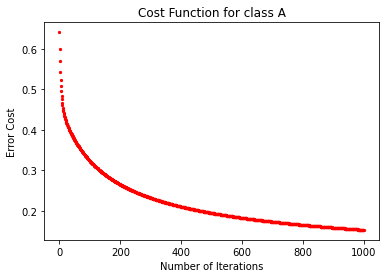

In [22]:
costA , thetaA = gradient_descent(trainX, yA, theta, alpha, iterations)

#Plot graph to visualize the cost function
plt.figure()
plt.title('Cost Function for class A')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Cost')

plt.scatter(x=list(range(iterations)) , y=costA, s=5, color="red")
plt.show()

Cost at iteration  0  =  0.6450024572715178
Cost at iteration  100  =  0.4274969763902116
Cost at iteration  200  =  0.4112320870813612
Cost at iteration  300  =  0.4044780070735804
Cost at iteration  400  =  0.40131204692700434
Cost at iteration  500  =  0.39969441206142425
Cost at iteration  600  =  0.39880657153544863
Cost at iteration  700  =  0.3982842835151765
Cost at iteration  800  =  0.3979534819414732
Cost at iteration  900  =  0.39772667466998257


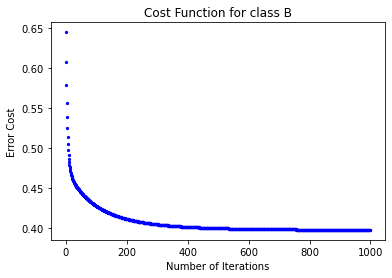

In [23]:
costB , thetaB = gradient_descent(trainX, yB, theta, alpha, iterations)

#Plot graph to visualize the cost function
plt.figure()
plt.title('Cost Function for class B')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Cost')

plt.scatter(x=list(range(iterations)) , y=costB, s=5, color="blue")
plt.show()

Cost at iteration  0  =  0.6489095516789768
Cost at iteration  100  =  0.48628500758449456
Cost at iteration  200  =  0.48467282502592435
Cost at iteration  300  =  0.48382886607109615
Cost at iteration  400  =  0.48323045555877553
Cost at iteration  500  =  0.4827279613669628
Cost at iteration  600  =  0.48227598545129113
Cost at iteration  700  =  0.4818594379542873
Cost at iteration  800  =  0.4814723247117292
Cost at iteration  900  =  0.48111149264784536


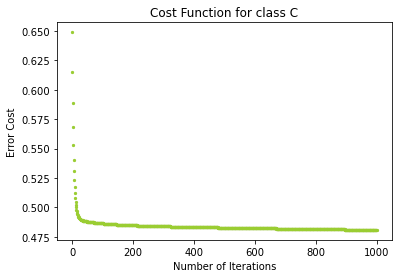

In [24]:
costC , thetaC = gradient_descent(trainX, yC, theta, alpha, iterations)

#Plot graph to visualize the cost function
plt.figure()
plt.title('Cost Function for class C')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Cost')

plt.scatter(x=list(range(iterations)) , y=costC, s=5, color="yellowgreen")
plt.show()

Cost at iteration  0  =  0.6397146725453519
Cost at iteration  100  =  0.43841663858429386
Cost at iteration  200  =  0.436595686450065
Cost at iteration  300  =  0.4359653517760027
Cost at iteration  400  =  0.43570256947049274
Cost at iteration  500  =  0.43555728949191336
Cost at iteration  600  =  0.4354530995307453
Cost at iteration  700  =  0.43536625675702306
Cost at iteration  800  =  0.4352890984352062
Cost at iteration  900  =  0.4352189161672258


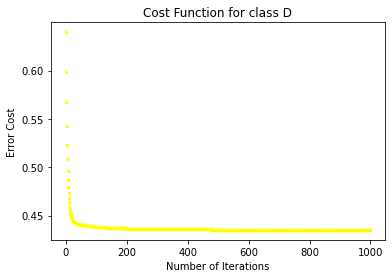

In [25]:
costD , thetaD = gradient_descent(trainX, yD, theta, alpha, iterations)

#Plot graph to visualize the cost function
plt.figure()
plt.title('Cost Function for class D')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Cost')

plt.scatter(x=list(range(iterations)) , y=costD, s=5, color="yellow")
plt.show()

Cost at iteration  0  =  0.6666614058727255
Cost at iteration  100  =  0.32809175602651086
Cost at iteration  200  =  0.2503309797950012
Cost at iteration  300  =  0.21278102338807636
Cost at iteration  400  =  0.18991979257610406
Cost at iteration  500  =  0.17418538373023212
Cost at iteration  600  =  0.16251199289026158
Cost at iteration  700  =  0.15340349621369065
Cost at iteration  800  =  0.14603486842338037
Cost at iteration  900  =  0.13990995369089454


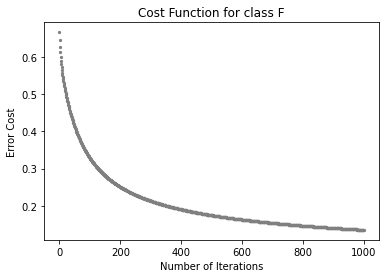

In [26]:
costF , thetaF = gradient_descent(trainX, yF, theta, alpha, iterations)

#Plot graph to visualize the cost function
plt.figure()
plt.title('Cost Function for class F')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Cost')

plt.scatter(x=list(range(iterations)) , y=costF, s=5, color="grey")
plt.show()

In [27]:
#predict for multi-class
def classpredict(X, theta):
    return sigmoid(X @ theta)

#predict final grade
def predictGrade(X):
    
    #calculate phypothesis for each class
    predA = classpredict(X, thetaA)
    predB = classpredict(X, thetaB)
    predC = classpredict(X, thetaC)
    predD = classpredict(X, thetaD)
    predF = classpredict(X, thetaF)
    
    #add all hypothesis in dataframe for easy comparison
    df = pd.concat([predA, predB, predC, predD, predF], axis=1)
    symbols = ['a', 'b', 'c','d', 'f']
    df.columns = symbols
    
    #find max of the hypothesis
    df['max'] = df[['a', 'b', 'c','d', 'f']].max(axis=1)
    
    #add the respective grade according to max hypothesis
    lists=[]
    for i in range(len(X)):
        lists.append((df.columns[(df == df.iloc[i]['max']).iloc[i]])[0])
    
    testing_data['predicted'] = lists
    
    #caluculate accuracy
    accuracyy(testing_data)
    
    #return data with original and predicted grades
    return testing_data

#calculate accuracy
def accuracyy(df):

    #compare if predicted grade is equal to actual grade
    df['accurate'] = df['predicted'].str.lower() == df['grade'].str.lower()
    
    #count number of correct and wrong predictions
    correct = df.accurate.value_counts().loc[True]
    wrong = df.accurate.value_counts().loc[False]
    
    #calculate accuracy of correct predicitons
    accuracy = (correct/len(df))*100
    
    #print accuracy
    print("Accuracy = " ,np.ceil(accuracy), "%")
    print("Correct Predictions= ", correct)
    print("Wrong Predictions= ", wrong)


In [28]:
#call prediciton method to predict grades of testing data and calculate accuracy
predictGrade(testingX)

Accuracy =  75.0 %
Correct Predictions=  148
Wrong Predictions=  50


,mid,final,grade,predicted,accurate
12,41.9,13.3,f,f,True
14,53.9,27.6,b,b,True
26,32.2,5.5,f,f,True
30,52.7,31.1,b,b,True
31,39.8,9.3,f,f,True
...,...,...,...,...,...
823,51.2,31.0,b,b,True
826,45.1,28.0,c,c,True
829,55.0,36.4,a,a,True
839,48.5,29.0,b,b,True


**Part 3: Regularization (6 points)**

Implement the regularization by adding the $\lambda$ and the new term in the cost function. Visualize the change in the hypothesis for different $\lambda$ values and calculating the success rate and cost for each one and drawing it in a graph.

In [29]:
def reg_cost(X,y,theta,lamda):
    m = len(y)
    hypothesis = sigmoid(X @ theta)
    cost = (1/m)*(((-y).T @ np.log(hypothesis))-((1-y).T @ np.log(1-hypothesis)))
    cost = cost + (lamda/(2*m))*(np.sum(np.power(theta,2)))
    return cost

In [30]:
def reg_descent_0(X, y, theta):
    return (X.T @ (sigmoid(X @ theta) - y))
        
def reg_descent(X,y,theta,lamda,m):
    return ((X.T @ (sigmoid(X @ theta) - y)) + (lamda/m) * theta)

def descent(X,y,theta,lamda,m):
    g0 = reg_descent_0(X,y,theta)
    g1 = reg_descent(X,y,theta,lamda,m)

    values = np.array([g0['X0'],g1['mid'],g1['final']])
    gradient = pd.Series(values,index=['X0','mid','final'])
    
    return gradient
    
def reg_gradient_descent(X, y, theta, rate, iterations, lamda):
    m = len(y)
    costs = []

    #find theta for the number of iterations
    for i in range(iterations):
        #calculate theta
        theta = theta - (rate/m) * descent(X,y,theta,lamda,m)
        #calculate cost
        c = cost(X, y, theta)
        costs.append(c)
        
        #print cost at each 100th iteration
        if(i % 100 == 0):
            print ("Cost at iteration ", i, " = ", c)

    return (costs, theta)

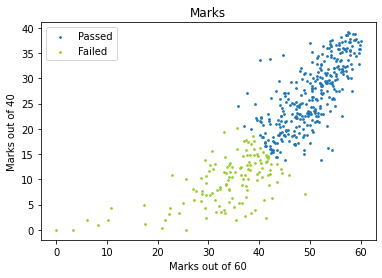

In [31]:
#Plot marks to see boundry line of passed and failed
plt.scatter(passed['mid'], passed['final'], s=3, label='Passed', )
plt.scatter(failed['mid'], failed['final'], s=3, label='Failed', color="yellowgreen")
plt.title('Marks')
plt.xlabel('Marks out of 60')
plt.ylabel('Marks out of 40')
plt.legend()
plt.show()

In [32]:
#Test with lamda = 50
c1, theta1 = reg_gradient_descent(trainX, trainY, theta, alpha, iterations, 50)
theta1

Cost at iteration  0  =  0.6666614058727254
Cost at iteration  100  =  0.32903583777430384
Cost at iteration  200  =  0.2521606345299313
Cost at iteration  300  =  0.21534002246444225
Cost at iteration  400  =  0.19312095942173027
Cost at iteration  500  =  0.17797169078014277
Cost at iteration  600  =  0.16684207191197442
Cost at iteration  700  =  0.1582453321962828
Cost at iteration  800  =  0.15136259087788365
Cost at iteration  900  =  0.14570200704758093


X0       2.049752
mid      6.314299
final    9.402243
dtype: float64

In [33]:
#Test with lamda = 1000
c2, theta2 = reg_gradient_descent(trainX, trainY, theta, alpha, iterations, 1000)
theta2

Cost at iteration  0  =  0.6666614058727254
Cost at iteration  100  =  0.34635709077801535
Cost at iteration  200  =  0.28527368025683075
Cost at iteration  300  =  0.2609880189703098
Cost at iteration  400  =  0.2492467565342949
Cost at iteration  500  =  0.2430353006678173
Cost at iteration  600  =  0.2395932676175661
Cost at iteration  700  =  0.2376367750820751
Cost at iteration  800  =  0.23650842624969373
Cost at iteration  900  =  0.2358520742078397


X0       1.356255
mid      3.304993
final    5.072859
dtype: float64

In [34]:
#prediction accuracy of test data with lamda 50
acc, correct, wrong = accuracy(theta1, testX, testY)
print("Accuracy with lamda 50 = ", acc, "%")
print("Correct predictions = ", correct)
print("Incorrect predictions = ", wrong)

print("---------------------------------")
#prediction accuracy of test data with lamda 1000
acc, correct, wrong = accuracy(theta2, testX, testY)
print("Accuracy with lamda 1000 = ", acc, "%")
print("Correct predictions = ", correct)
print("Incorrect predictions = ", wrong)

Accuracy with lamda 50 =  96.96969696969697 %
Correct predictions =  192
Incorrect predictions =  6
---------------------------------
Accuracy with lamda 1000 =  97.97979797979798 %
Correct predictions =  194
Incorrect predictions =  4


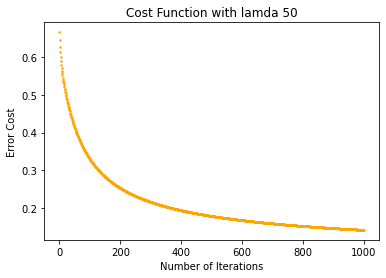

In [35]:
#Plot graph to visualize the cost function of lamda 50
plt.figure()
plt.title('Cost Function with lamda 50')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Cost')

plt.scatter(x=list(range(iterations)) , y=c1, s=2, color="orange")
plt.show()

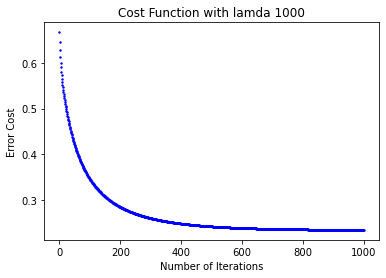

In [36]:
#Plot graph to visualize the cost function with lamda 1000
plt.figure()
plt.title('Cost Function with lamda 1000')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Cost')

plt.scatter(x=list(range(iterations)) , y=c2, s=2, color="blue")
plt.show()